In [149]:
from curves import bootstrap_contracts, max_smooth_interp, contract_period as cp, weighting, adjustments
from collections import namedtuple

PowerCurvePoint = namedtuple("PowerCurvePoint", "contract baseload_price peak_price")

curve_prices = [
    PowerCurvePoint(cp.jul(2022), 17.45, 29.55),
    PowerCurvePoint(cp.aug(2022), 16.23, 32.89),
    PowerCurvePoint(cp.q_3(2022), 17.41, 28.99),
    PowerCurvePoint(cp.q_4(2022), 21.07, 41.96),
    PowerCurvePoint(cp.q_1(2023), 22.84, 43.82),
    PowerCurvePoint(cp.summer(2023), 15.53, 28.65),
    PowerCurvePoint(cp.winter(2023), 20.98, 40.02)
]

In [150]:
# For simplicity same shaping ratios used for peak and offpeak, probably they should be different
shaping_ratios = [
    # month to quarter shaping
    (cp.dec(2022), cp.q_4(2022), 1.19),
    (cp.nov(2022), cp.q_4(2022), 0.96),
    (cp.jan(2023), cp.q_1(2023), 1.25),
    (cp.feb(2023), cp.q_1(2023), 1.08),
    
    # month to month shaping
    # Q2-23
    (cp.apr(2023), cp.may(2023), 1.05),
    (cp.may(2023), cp.jun(2023), 1.02),
    # Q3-23
    (cp.jul(2023), cp.aug(2023), 1.02),
    (cp.aug(2023), cp.sep(2023), 0.94),
    # Q4-23
    (cp.dec(2023), cp.nov(2023), 1.12),
    (cp.nov(2023), cp.oct(2023), 1.02),
    # Q1-24
    (cp.jan(2024), cp.feb(2024), 1.08),
    (cp.feb(2024), cp.mar(2024), 1.03),
        
    # quarter to quarter shaping
    (cp.q_2(2023), cp.q_3(2023), 0.98),
    (cp.q_4(2023), cp.q_1(2024), 0.96)
]

peak_intra_week_shaping = adjustments.dayofweek(
    monday=0.97,
    tuesday=1.01,
    wednesday=1.03,
    thursday=1.00,
    friday=0.96,
    default=1.0
)

offpeak_intra_week_shaping = adjustments.dayofweek(
    default=1.0, # Assume no weekday shape for offpeak, might not be realistic
    saturday=0.85,
    sunday=0.81
)

# Shaping to 4-hour blocks, ratio of block price to daily price
weekend_block_ratios = {
    0 : 0.84,
    4 : 0.88,
    8 : 1.09,
    12 : 1.12,
    16 : 1.09,
    20 : 0.91
}

weekday_peak_block_ratios = {
    8 : 0.98,
    12 : 1.03,
    16 : 0.94
}

weekday_offpeak_block_ratios = {
    0 : 0.96,
    4 : 0.98,
    20 : 1.04
}

def normalise_to_1_average(block_ratios):
    sum_ratios=0.0
    for ratio in block_ratios.values():
        sum_ratios+=ratio
    avg_ratio = sum_ratios/len(block_ratios)
    return {key: value/avg_ratio for (key, value) in block_ratios.items()}

weekend_block_ratios = normalise_to_1_average(weekend_block_ratios)
weekday_peak_block_ratios = normalise_to_1_average(weekday_peak_block_ratios)
weekday_offpeak_block_ratios = normalise_to_1_average(weekday_offpeak_block_ratios)

<AxesSubplot:title={'center':'Bootstrapped and Shaped Peak Curve'}>

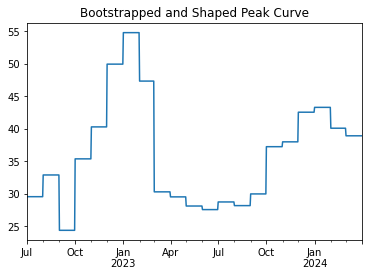

In [151]:
# Bootstrap and Shape Peak Prices to Monthly
raw_peak_curve_points = [(pcp.contract, pcp.peak_price) for pcp in curve_prices]

peak_weighting = weighting.num_weekdays()

monthly_peak_curve, bootstrapped_peak_contracts = \
    bootstrap_contracts(freq='M', contracts=raw_peak_curve_points, shaping_ratios=shaping_ratios, 
                       average_weight=peak_weighting)
piecewise_daily_peak_curve = monthly_peak_curve.resample('D').fillna('pad')

%matplotlib inline
piecewise_daily_peak_curve.plot(title='Bootstrapped and Shaped Peak Curve')


<AxesSubplot:title={'center':'Smoothed Versus Piecewise Daily Peak Curve'}>

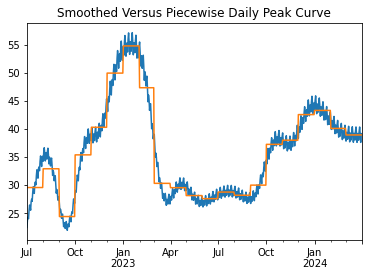

In [152]:
# Apply Spline to Calculate Daily Peak Price with Intra-week Shaping

daily_peak_price = max_smooth_interp(monthly_peak_curve, freq='D', mult_season_adjust=peak_intra_week_shaping,
                                    average_weight=peak_weighting)
daily_peak_price.plot(title='Smoothed Versus Piecewise Daily Peak Curve')
piecewise_daily_peak_curve.plot()

In [153]:
# Derive offpeak prices
import pandas as pd

def offpeak_weighting(period):
    wkend_mask = "Sat Sun"
    wkend_freq=pd.offsets.CustomBusinessDay(weekmask=wkend_mask)
    start_day = period.asfreq('D', 's').to_timestamp()
    end_day = period.asfreq('D', 'e').to_timestamp()
    num_wkend_days = len(pd.date_range(start=start_day, end=end_day, freq=wkend_freq))
    num_wk_days = len(pd.date_range(start=start_day, end=end_day, freq='B'))
    return num_wkend_days*2 + num_wk_days

offpeak_contracts = []
for curve_price in curve_prices:
    contract = curve_price.contract
    peak_weight = peak_weighting(contract)
    offpeak_weight = offpeak_weighting(contract)
    total_weight = peak_weight + offpeak_weight
    offpeak_price = (curve_price.baseload_price * total_weight - curve_price.peak_price * peak_weight)/offpeak_weight
    offpeak_contracts.append((contract, offpeak_price))


<AxesSubplot:title={'center':'Smoothed Versus Piecewise Daily Offpeak Curve'}>

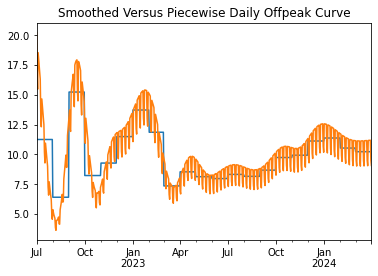

In [154]:
# Bootstrap and Shape Offpeak Prices to Monthly
monthly_offpeak_curve, bootstrapped_offpeak_contracts = \
    bootstrap_contracts(freq='M', contracts=offpeak_contracts, shaping_ratios=shaping_ratios, # TODO use different shaping ratios
                       average_weight=offpeak_weighting)
piecewise_daily_offpeak_curve = monthly_offpeak_curve.resample('D').fillna('pad')

# Apply Spline to Calculate Daily Offpeak Price with Intra-week Shaping

daily_peak_price = max_smooth_interp(monthly_offpeak_curve, freq='D', mult_season_adjust=offpeak_intra_week_shaping,
                                    average_weight=offpeak_weighting)

%matplotlib inline
piecewise_daily_offpeak_curve.plot(title='Smoothed Versus Piecewise Daily Offpeak Curve')
daily_peak_price.plot()